# Сборный проект
# Исследование рынка видеоигр
В нашем распоряжении данные из открытых источников о продажах игр, оценках пользователей и критиков, жанрах и платформах (например, Xbox или PlayStation) до 2016 года. Нам нужно провести исследование для международного магазина видеоигр: на исторических данных выявить определяющие успешность игры закономерности.

## Анализ данных об играх
### 1) Данные

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import warnings
warnings.simplefilter('ignore')

In [2]:
data = pd.read_csv('/datasets/games.csv')
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [3]:
data.columns = data.columns.str.lower()

In [4]:
data.shape

(16715, 11)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [6]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Как видим, в 6 колонках датасета из 11 присутствуют пустые значения, а некоторые признаки приведены к неправильному типу данных.  
Давайте это исправим! 

### 2) Препроцессинг данных

In [7]:
data[data['name'].isna() | data['genre'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


- **name, genre**  
  В колонках названия и жанра игры есть по 2 пропущенных значения. Вероятно, они были утеряны по техническим причинам.    
  После детального рассмотрения стало понятно, что речь идёт об одних и тех же строках.  
  Пытаться восстановить данные такого характера практически невозможно, поэтому следует исключить их из рассмотрения.

-  **year_of_release**  
  В случае неуказанного года релиза игры стоит обратить внимание на годы выпуска этой же игры на других платформах.  
  Велика вероятность, что даты окажутся близкими или совсем идентичными, поэтому сгруппируем данные по названиям игр.    
  Случаи, когда этот метод не сработал, следует удалить из набора. Можно предположить, что отсутствие значений напрямую связано с мультиплатформенными релизами.  
  После всех манипуляций переведём столбец к формату даты.  

- **critic_score**  
  Оценки критиков больше являются категориальной переменной, нежели количественной,  
  поэтому для отсутствующих значений лучше будет создать отдельную категорию, заполнив её значением, которое не может считаться оценкой (-999).  
  Появление этих пропусков может быть следствием невысокой популярности игры, либо же отсутствия соответствующих платформ и изданий на момент выхода игры.  
  Приведём эту колонку к целочисленному формату, так как использование вещественного типа не оправдано.   

- **user_score**  
  Оценки пользователей тоже указаны не везде. Аббревиатура "TBD" расшифровывается как "To Be Determined" - это свидетельствует о том, что пользовательская оценка ещё попросту не сформировалась.  
  Замением "TBD" на пустое значение и оформим отсутствующие значения отдельной категорией (-999), как поступили и с оценками критиков.  

- **rating**  
  Пустые значения в колонке возрастного рейтинга отметим буквально неоценёнными (Not Rated).  

Такой набор несложных манипуляций позволил нам избавиться от пропущенных значений в датасете.  
Последним шагом будет удаление явных дубликатов, которые могли быть в данных изначально или сформировались после заполения пропусков.  

In [8]:
data = data.dropna(subset=['name'])

data['year_of_release'] = data['year_of_release'].fillna(data.groupby(by='name')['year_of_release'].transform('median'))
data = data.dropna(subset=['year_of_release'])
data['year_of_release'] = pd.to_datetime(data['year_of_release'], format='%Y').dt.year

data['critic_score'] = data['critic_score'].fillna(-999).astype('int')

data['user_score'] = data['user_score'].replace('tbd', np.nan)
data['user_score'] = data['user_score'].fillna(-999).astype('float64')

data['rating'] = data['rating'].fillna('Not Rated')

data = data.drop_duplicates()

In [9]:
data['total_sales'] = data[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis='columns')

In [10]:
data.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-999,-999.0,Not Rated,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-999,-999.0,Not Rated,31.38


In [11]:
print('Наличие явных дубликатов в датасете: ', data.duplicated().value_counts())
print('Пропущенных значений в датасете:', data.isna().sum().sum())

Наличие явных дубликатов в датасете:  False    16567
dtype: int64
Пропущенных значений в датасете: 0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16567 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16567 non-null  object 
 1   platform         16567 non-null  object 
 2   year_of_release  16567 non-null  int64  
 3   genre            16567 non-null  object 
 4   na_sales         16567 non-null  float64
 5   eu_sales         16567 non-null  float64
 6   jp_sales         16567 non-null  float64
 7   other_sales      16567 non-null  float64
 8   critic_score     16567 non-null  int64  
 9   user_score       16567 non-null  float64
 10  rating           16567 non-null  object 
 11  total_sales      16567 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 1.6+ MB


Данные успешно зачищены от пустных ячеек и явных дубликатов.  
Сформирован новый признак суммарных продаж.

### 3) Анализ данных  
#### Посмотрим, сколько игр выпускалось в разные годы.

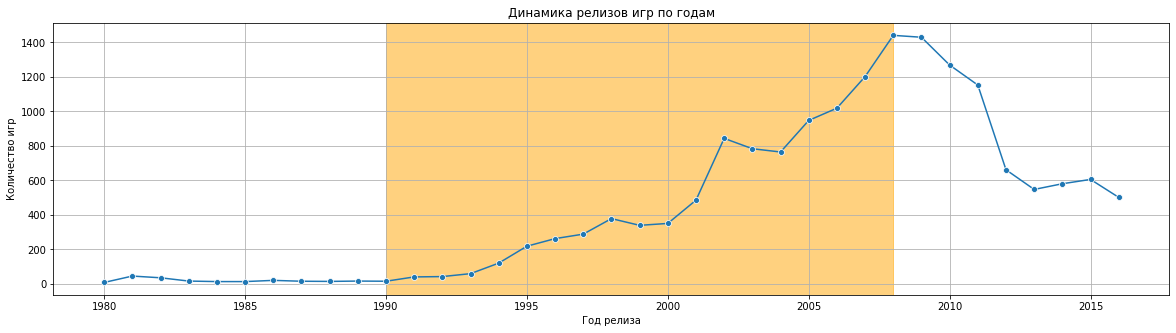

In [13]:
plt.figure(figsize=(20, 5))
plt.title('Динамика релизов игр по годам')
plt.ylabel('Количество игр')
plt.xlabel('Год релиза')
plt.axvspan(1990, 2008, color='orange', alpha=0.5)
plt.grid(True)
sns.lineplot(data=data.groupby('year_of_release')['name'].count(), marker='o')
plt.show()

По графику видно, что игровая индустрия начала стремительно набирать обороты после 1990 года.  
Пик был достигнут в 2008 году, а далее количество выпускаемых игр пошло на спад.   
Вероятно, показатели пошли на снижение из-за мирового кризиса 2008 года, который повлиял и на игровую индустрию.

#### Теперь изучим, как менялись продажи по платформам и характерные сроки появления/исчезновения платформ.

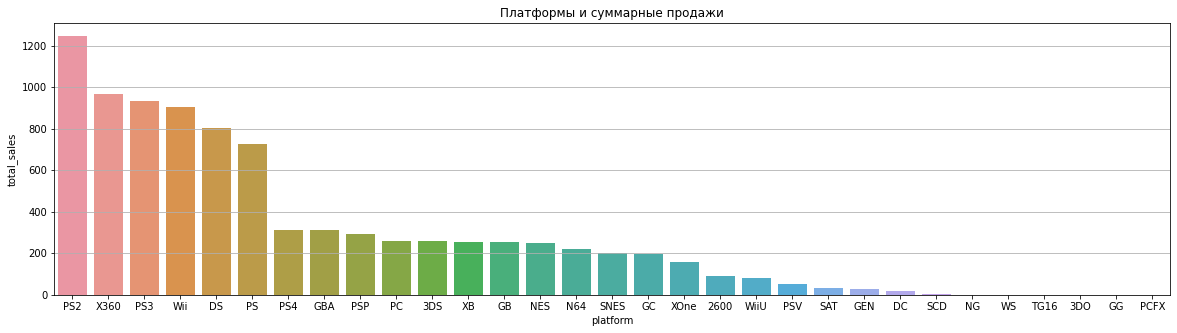

In [14]:
sales_by_platform = data.pivot_table(index='platform', values='total_sales', aggfunc='sum')\
                        .sort_values(by='total_sales', ascending=False)

plt.figure(figsize=(20, 5))
plt.title('Платформы и суммарные продажи')
plt.ylabel('Продажи')
plt.xlabel('Платформа')
plt.grid(True)
sns.barplot(x=sales_by_platform.index, y=sales_by_platform['total_sales'])
plt.show()

Лидирующие позиции заняли 6 платформ - PS2, X360, PS3, Wii, DS и PS.  
На текущий момент времени эти данные вряд ли можно считать актуальными, но на момент их выгрузки всё верно -  
платформы PS4 и XOne тогда ещё не были настолько популярными, а PS5 вовсе не существовало.

#### Рассмотрим 6 лидирующих платформ детальнее.

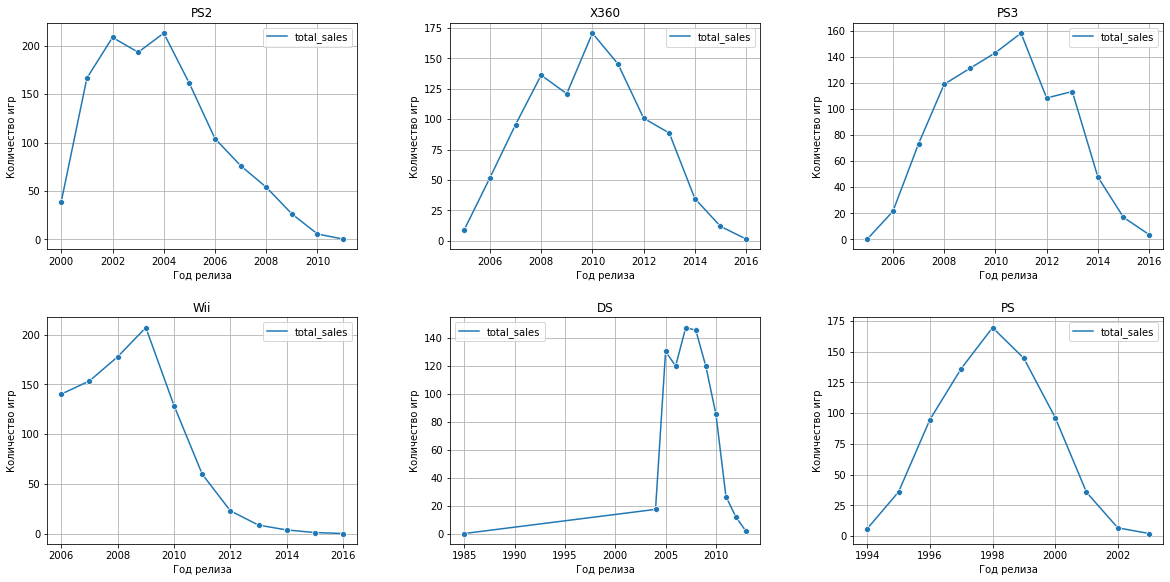

In [15]:
best_platforms = sales_by_platform.reset_index()['platform'].head(6)
plt.figure(figsize=(20, 15))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
cell = 1

for platforms in best_platforms:
    plt.subplot(3, 3, cell)
    plt.title(f'{platforms}')
    plt.ylabel('Количество игр')
    plt.xlabel('Год релиза')
    plt.grid(True)
    sns.lineplot(data=data.query('platform == @platforms').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum'), marker='o')
    cell += 1
plt.show()

Среди представленных выше платформ наблюдается спад популярности к 2016 году, либо же раньше.

In [16]:
lifelines = []
for platform in best_platforms:
    lifelines.append(data.query('(platform == @platform)').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').count())
int(np.median(lifelines))

11

Средний жизненный цикл платформы составил ~11 лет.

Учитывая заключения, к которым мы пришли выше и даты выхода актуальных на тот момент консолей, таких как PS4, можно сделать вывод, что для прогноза на 2017 год целесообразно будет использовать данные после 2013 года.

In [17]:
data_for_forecast = data.query('year_of_release > 2013')
data_for_forecast['platform'].unique()

array(['PS4', '3DS', 'XOne', 'WiiU', 'PS3', 'X360', 'PC', 'Wii', 'PSV',
       'PSP'], dtype=object)

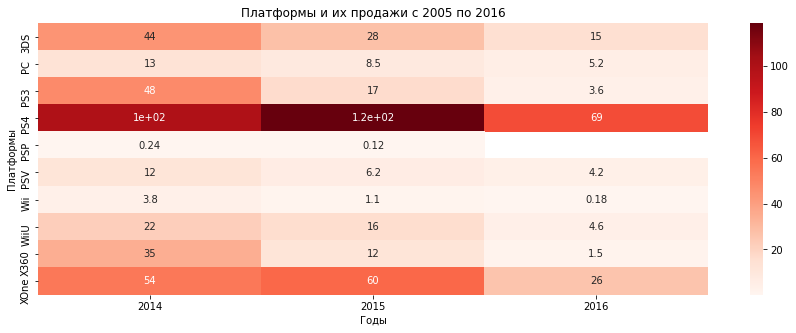

In [18]:
plt.figure(figsize=(15, 5))
plt.title('Платформы и их продажи с 2005 по 2016')
sns.heatmap(data_for_forecast.pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='sum'), annot=True, cmap="Reds")
plt.ylabel('Платформы')
plt.xlabel('Годы')
plt.show()

По тепловой карте видно, что наиболее перспективными на 2017 год являлись платфомы PS4, XOne, 3DS, PC и WiiU.

#### Построим «ящики с усами» по глобальным продажам игр в разбивке по платформам

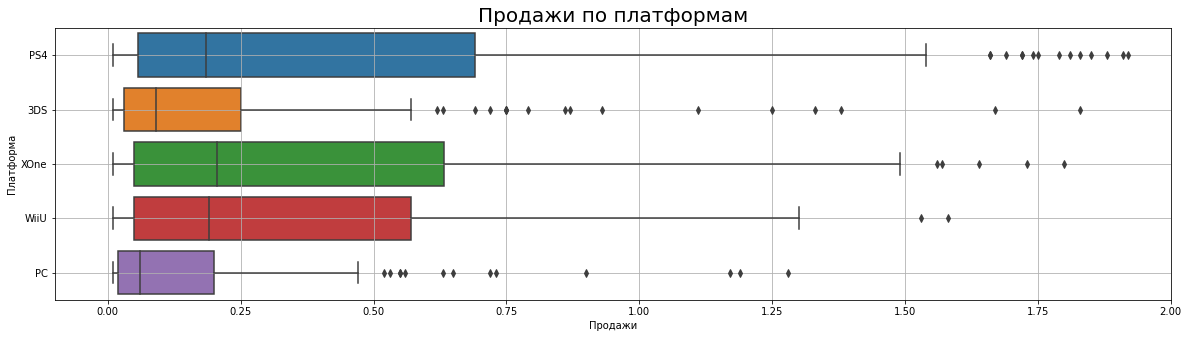

In [19]:
plt.figure(figsize=(20, 5))
plt.xlim(-0.1, 2)
plt.title('Продажи по платформам', fontsize=20)
sns.boxplot(x='total_sales', y='platform',
            data=data_for_forecast[data_for_forecast['platform'].isin(['PS4', 'XOne', '3DS', 'PC', 'WiiU'])],
            orient='h')
plt.ylabel('Платформа')
plt.xlabel('Продажи')
plt.grid(True)

**PS4**

In [20]:
data_for_forecast[(data_for_forecast['platform'].isin(['PS4'])) &
                  (data_for_forecast['critic_score'] != -999) &
                  (data_for_forecast['user_score'] != -999)]['total_sales'].describe()

count    234.000000
mean       0.936752
std        1.659319
min        0.010000
25%        0.070000
50%        0.260000
75%        0.930000
max       12.620000
Name: total_sales, dtype: float64

**XOne**

In [21]:
data_for_forecast[(data_for_forecast['platform'].isin(['XOne'])) &
                  (data_for_forecast['critic_score'] != -999) &
                  (data_for_forecast['user_score'] != -999)]['total_sales'].describe()

count    151.000000
mean       0.763510
std        1.054732
min        0.010000
25%        0.110000
50%        0.320000
75%        1.070000
max        5.470000
Name: total_sales, dtype: float64

**3DS**

In [22]:
data_for_forecast[(data_for_forecast['platform'].isin(['3DS'])) &
                  (data_for_forecast['critic_score'] != -999) &
                  (data_for_forecast['user_score'] != -999)]['total_sales'].describe()

count    47.000000
mean      0.515106
std       0.797899
min       0.010000
25%       0.085000
50%       0.240000
75%       0.480000
max       3.890000
Name: total_sales, dtype: float64

**WiiU**

In [23]:
data_for_forecast[(data_for_forecast['platform'].isin(['WiiU'])) &
                  (data_for_forecast['critic_score'] != -999) &
                  (data_for_forecast['user_score'] != -999)]['total_sales'].describe()

count    42.000000
mean      0.805476
std       1.305153
min       0.010000
25%       0.122500
50%       0.430000
75%       0.820000
max       7.090000
Name: total_sales, dtype: float64

**PC**

In [24]:
data_for_forecast[(data_for_forecast['platform'].isin(['PC'])) &
                  (data_for_forecast['critic_score'] != -999) &
                  (data_for_forecast['user_score'] != -999)]['total_sales'].describe()

count    115.000000
mean       0.207043
std        0.354141
min        0.010000
25%        0.030000
50%        0.100000
75%        0.235000
max        3.050000
Name: total_sales, dtype: float64

- Медианы у платформ-лидеров находятся дальше остальных. Разброс больше, так как больше и продаж.
- Размах усов для ящиков ограничен минимумом и максимумом, и он выделяется у PS4, XOne и WiiU

**Можно сделать вывод, что лучше всего игры продаются на PS4, XOne и WiiU**

#### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.  

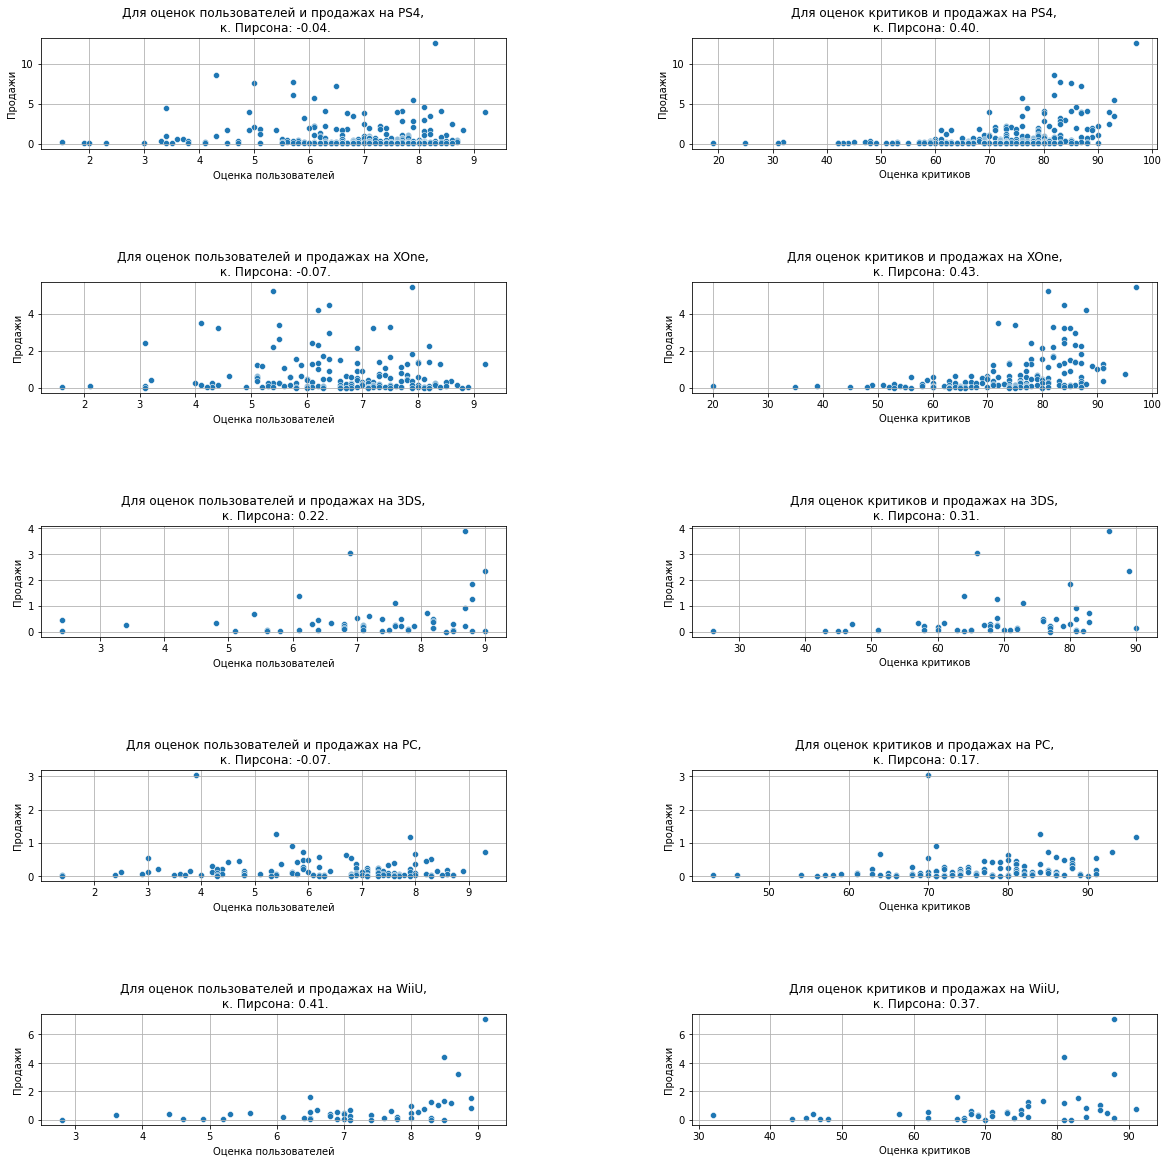

In [25]:
cell = 0
best_platforms_data = data_for_forecast[data_for_forecast['platform'].isin(['PS4', 'XOne', '3DS', 'PC', 'WiiU'])]

plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0.4, hspace=1.2)

for platform in ['PS4', 'XOne', '3DS', 'PC', 'WiiU']:
    cell += 1
    data_for_diagram = best_platforms_data[(best_platforms_data['platform'] == platform) & (best_platforms_data['user_score'] != -999)]
    
    plt.subplot(5, 2, cell)
    corr_value = data_for_diagram['total_sales'].corr(data_for_diagram['user_score'])
    plt.title(f'Для оценок пользователей и продажах на {platform},\n к. Пирсона: {corr_value:.2f}.', fontsize=12)
    sns.scatterplot(x='user_score', y='total_sales', data=data_for_diagram)
    plt.xlabel('Оценка пользователей')
    plt.ylabel('Продажи')
    plt.grid(True)
    
    cell += 1
    plt.subplot(5, 2, cell)
    data_for_diagram = best_platforms_data[(best_platforms_data['platform'] == platform) & (best_platforms_data['critic_score'] != -999)]
    corr_value = data_for_diagram['total_sales'].corr(data_for_diagram['critic_score'].astype('float32'))
    plt.title(f'Для оценок критиков и продажах на {platform},\n к. Пирсона: {corr_value:.2f}.', fontsize=12)
    sns.scatterplot(x='critic_score', y='total_sales', data=data_for_diagram)
    plt.xlabel('Оценка критиков')
    plt.ylabel('Продажи')
    plt.grid(True)

Возьмём в качестве конкретного примера платформу PS4:
- Коэффицент корреляции для оценки критиков положительный
- Мнение критиков имеет корреляцию выше, чем пользовательское

Взглянем на общую картину:
- Самое сильная корреляция отзывов критиков и пользователей у консоли WiiU и 3DS, а самая слабая у PC
- Мнение критиков в большинстве случаев превосходит пользовательское в показателях корреляции с продажами

#### Общее распределение игр по жанрам

Text(0.5, 0, 'Жанр')

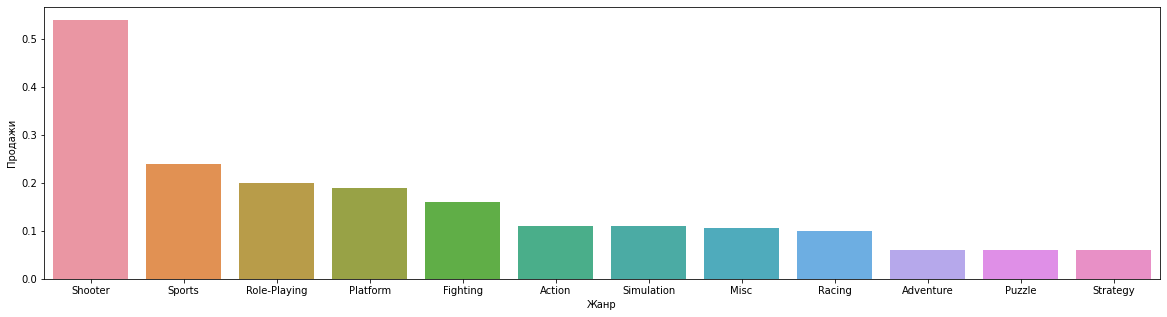

In [38]:
plt.figure(figsize=(20, 5))
sns.barplot(x='genre', y='total_sales',
            data=best_platforms_data.pivot_table(index='genre', values='total_sales', aggfunc='median').sort_values(by='total_sales', ascending=False).reset_index())
plt.ylabel('Продажи')
plt.xlabel('Жанр')

Самыми прибыльными оказались шутеры, а их полной противоположностью - жанр стратегий.  
Шутеры, спорт, ролевые игры, платформеры и файтинги - самые популярные жанры.

**Вывод:**  
- Итого, мы пришли к выводам, что средняя продолжительность жизни платформы - 11 лет.  
- Наиболее перспективными платформами на 2017 год являлись PS4, XOne, WiiU, 3DS и PC.  
- Оценки и отзывы критиков чаще играют роль, нежели пользовательские. Самым популярным и прибыльным оказался жанр шутеров.

### 4) Портрет пользователя

#### Северная Америка

##### Платформы

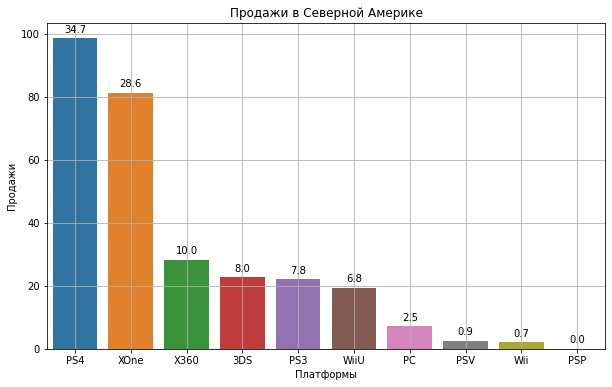

In [27]:
na_data = data_for_forecast.pivot_table(index='platform', values='na_sales', aggfunc='sum')\
                           .sort_values(by='na_sales', ascending=False).reset_index()
sum_sales = na_data['na_sales'].sum()
plt.figure(figsize=(10, 6))
sales = sns.barplot(x='platform', y='na_sales', data=na_data)
plt.title('Продажи в Северной Америке')
plt.ylabel('Продажи')
plt.xlabel('Платформы')
plt.grid(True)

for patch in sales.patches:
    sales.annotate(format(patch.get_height() / sum_sales * 100, '.1f'), 
                        (patch.get_x() + patch.get_width() / 2., patch.get_height()), 
                        ha='center', va='center', xytext=(0, 9), textcoords='offset points')

- В Северной Америке самыми популярными платформами являются:
    1. PS4 - 34.7% рынка
    2. XOne - 28.6% рынка
    3. X360 - 10% рынка
    4. 3DS - 8% рынка
    5. PS3 - 7.8% рынка

##### Жанры

Text(0.5, 0, 'Жанры')

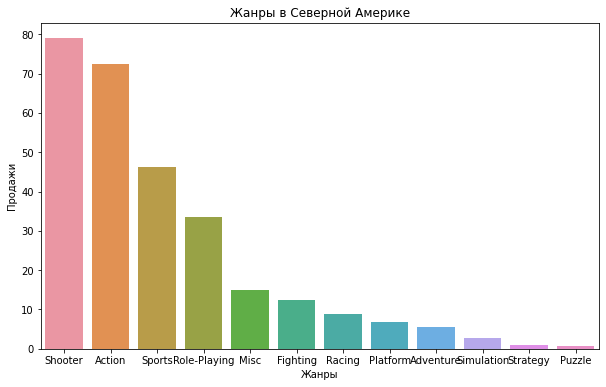

In [28]:
na_data = data_for_forecast.pivot_table(index='genre', values='na_sales', aggfunc='sum')\
                           .sort_values(by='na_sales', ascending=False).reset_index()
sum_sales = na_data['na_sales'].sum()
plt.figure(figsize=(10, 6))
sales = sns.barplot(x='genre', y='na_sales', data=na_data)
plt.title('Жанры в Северной Америке')
plt.ylabel('Продажи')
plt.xlabel('Жанры')

- В Северной Америке самыми популярными жанрами являются:
    1. Shooter
    2. Action
    3. Sports
    4. Role-Playing
    5. Misc

##### Рейтинг ESRB

Text(0.5, 0, 'Рейтинг')

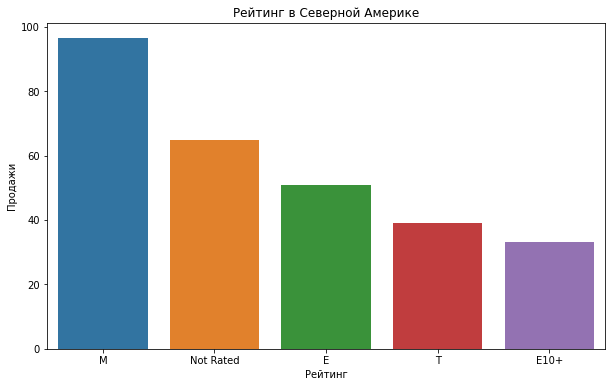

In [29]:
na_data = data_for_forecast.pivot_table(index='rating', values='na_sales', aggfunc='sum')\
                           .sort_values(by='na_sales', ascending=False).reset_index()
sum_sales = na_data['na_sales'].sum()
plt.figure(figsize=(10, 6))
sales = sns.barplot(x='rating', y='na_sales', data=na_data)
plt.title('Рейтинг в Северной Америке')
plt.ylabel('Продажи')
plt.xlabel('Рейтинг')

- В Северной Америке самыми популярными рейтингами являются:
    1. M
    2. Not Rated
    3. E
    4. T
    5. E10+

#### Европа

##### Платформы

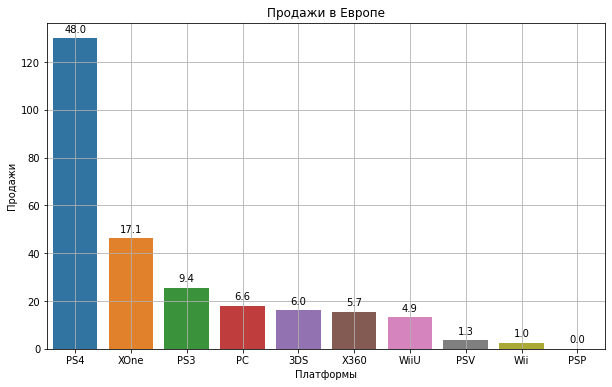

In [30]:
eu_data = data_for_forecast.pivot_table(index='platform', values='eu_sales', aggfunc='sum')\
                           .sort_values(by='eu_sales', ascending=False).reset_index()
sum_sales = eu_data['eu_sales'].sum()
plt.figure(figsize=(10, 6))
sales = sns.barplot(x='platform', y='eu_sales', data=eu_data)
plt.title('Продажи в Европе')
plt.ylabel('Продажи')
plt.xlabel('Платформы')
plt.grid(True)

for patch in sales.patches:
    sales.annotate(format(patch.get_height() / sum_sales * 100, '.1f'), 
                        (patch.get_x() + patch.get_width() / 2., patch.get_height()), 
                        ha='center', va='center', xytext=(0, 9), textcoords='offset points')

- В Европе самыми популярными платформами являются:
    1. PS4 - 48% рынка
    2. XOne - 17.1% рынка
    3. PS3 - 9.4% рынка
    4. PC - 6.6% рынка
    5. 3DS - 6% рынка

##### Жанры

Text(0.5, 0, 'Жанры')

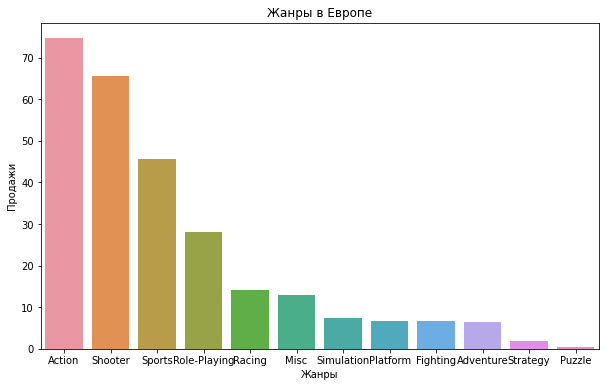

In [31]:
eu_data = data_for_forecast.pivot_table(index='genre', values='eu_sales', aggfunc='sum')\
                           .sort_values(by='eu_sales', ascending=False).reset_index()
sum_sales = eu_data['eu_sales'].sum()
plt.figure(figsize=(10, 6))
sales = sns.barplot(x='genre', y='eu_sales', data=eu_data)
plt.title('Жанры в Европе')
plt.ylabel('Продажи')
plt.xlabel('Жанры')

- В Европе самыми популярными жанрами являются:
    1. Action
    2. Shooter
    3. Sports
    4. Role-Playing
    5. Racing

##### Рейтинг ESRB

Text(0.5, 0, 'Рейтинг')

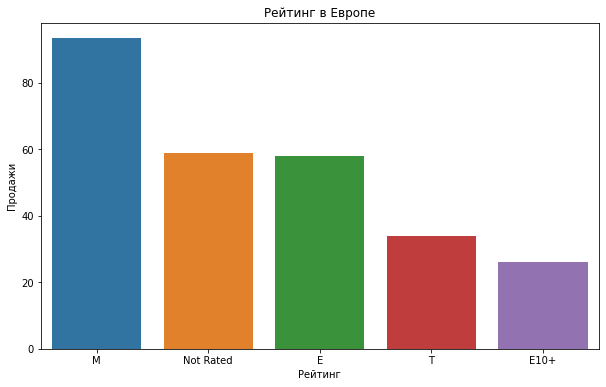

In [32]:
eu_data = data_for_forecast.pivot_table(index='rating', values='eu_sales', aggfunc='sum')\
                           .sort_values(by='eu_sales', ascending=False).reset_index()
sum_sales = eu_data['eu_sales'].sum()
plt.figure(figsize=(10, 6))
sales = sns.barplot(x='rating', y='eu_sales', data=eu_data)
plt.title('Рейтинг в Европе')
plt.ylabel('Продажи')
plt.xlabel('Рейтинг')

- В Европе самыми популярными рейтингами являются:
    1. M
    2. Not Rated
    3. E
    4. T
    5. E10+

#### Япония
##### Платформы

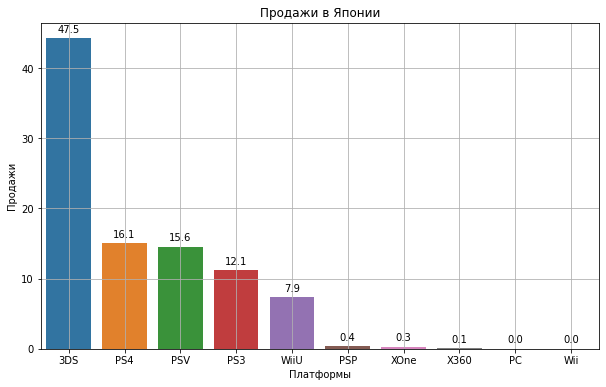

In [33]:
jp_data = data_for_forecast.pivot_table(index='platform', values='jp_sales', aggfunc='sum')\
                           .sort_values(by='jp_sales', ascending=False).reset_index()
sum_sales = jp_data['jp_sales'].sum()
plt.figure(figsize=(10, 6))
sales = sns.barplot(x='platform', y='jp_sales', data=jp_data)
plt.title('Продажи в Японии')
plt.ylabel('Продажи')
plt.xlabel('Платформы')
plt.grid(True)

for patch in sales.patches:
    sales.annotate(format(patch.get_height() / sum_sales * 100, '.1f'), 
                        (patch.get_x() + patch.get_width() / 2., patch.get_height()), 
                        ha='center', va='center', xytext=(0, 9), textcoords='offset points')

- В Японии самыми популярными платформами являются:
    1. 3DS - 47.5% рынка
    2. PS4 - 16.1% рынка
    3. PSV - 15.6% рынка
    4. PS3 - 12.1% рынка
    5. WiiU - 7.9% рынка

##### Жанры

Text(0.5, 0, 'Жанры')

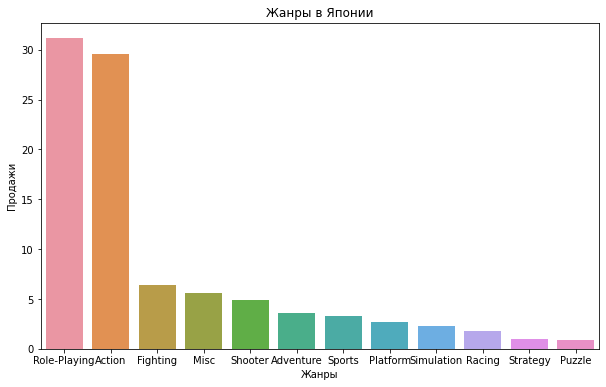

In [39]:
jp_data = data_for_forecast.pivot_table(index='genre', values='jp_sales', aggfunc='sum')\
                           .sort_values(by='jp_sales', ascending=False).reset_index()
sum_sales = jp_data['jp_sales'].sum()
plt.figure(figsize=(10, 6))
sales = sns.barplot(x='genre', y='jp_sales', data=jp_data)
plt.title('Жанры в Японии')
plt.ylabel('Продажи')
plt.xlabel('Жанры')

- В Японии самыми популярными жанрами являются:
    1. Role-Playing
    2. Action
    3. Fighting
    4. Misc
    5. Shooter

##### Рейтинг ESRB

Text(0.5, 0, 'Рейтинг')

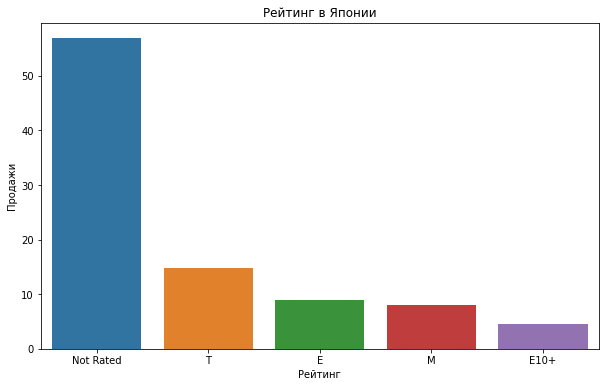

In [35]:
jp_data = data_for_forecast.pivot_table(index='rating', values='jp_sales', aggfunc='sum')\
                           .sort_values(by='jp_sales', ascending=False).reset_index()
sum_sales = jp_data['jp_sales'].sum()
plt.figure(figsize=(10, 6))
sales = sns.barplot(x='rating', y='jp_sales', data=jp_data)
plt.title('Рейтинг в Японии')
plt.ylabel('Продажи')
plt.xlabel('Рейтинг')

- В Японии самыми популярными рейтингами являются:
    1. Not Rated
    2. T
    3. E
    4. M
    5. E10+

**Вывод:** Предпочтения по жанрам и платформам сильно варьируются в зависимости от регионов продаж.  
Возрастные рейтинги тоже не стоит оставлять без внимания.

### 5) Проверка гипотез

**Гипотеза №1** Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

In [36]:
alpha = .05

XOne_data = data_for_forecast.query('(platform == "XOne") and (user_score != -999)')['user_score']
PC_data = data_for_forecast.query('(platform == "PC") and (user_score != -999)')['user_score']

results = st.ttest_ind(XOne_data, PC_data)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Средние пользовательские рейтинги платформ Xbox One и PC разные")
else:
    print("Средние пользовательские рейтинги платформ Xbox One и PC одинаковые")

p-значение: 0.10450507919348415
Средние пользовательские рейтинги платформ Xbox One и PC одинаковые


**Гипотеза №2** Средние пользовательские рейтинги жанров Action и Sports разные.

In [37]:
alpha = .05

action_data = data_for_forecast.query('(genre=="Action") and (user_score != -999)')['user_score']
sports_data = data_for_forecast.query('(genre=="Sports") and (user_score != -999)')['user_score']

results = st.ttest_ind(
    action_data, 
    sports_data)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Средние пользовательские рейтинги жанров Action и Sports разные")
else:
    print("Средние пользовательские рейтинги жанров Action и Sports одинаковые")

p-значение: 2.8711147985105864e-19
Средние пользовательские рейтинги жанров Action и Sports разные


### 6) Вывод

- Проведя большое исследование, мы смогли прийти к некоторым заключениям об учёте параметров перспективных продуктов игровой индустрии:
    - Учёт популярности платформ позволяет тщательнее подбирать продукты для определенных рынков
    - Учёт популярности жанров позволяет регулировать охват аудитории
    - Учёт возрастного рейтинга позволяет более точечно работать на целевую аудиторию  
&nbsp;
- **Перспективы регионов**:
    1. Северная Америка
        - Платформа: PS4, XOne
        - Жанр: Action, Shooter
        - Рейтинг: M, Not Rated
    2. Европа
        - Платформа: PS4, XOne
        - Жанр: Action, Shooter
        - Рейтинг: M, Not Rated
    3. Япония
        - Платформа: 3DS, PS4
        - Жанр: Role-Playing, Action
        - Рейтинг: Not Rated, T  
&nbsp; 
- На основании этих показателей можно сделать вывод, что за годы развития игровой индустрии предпочтения европейских и американских игроков стали схожими и только в Японии прослеживается наличие особой аудитории, что вызвано разностью менталитетов.    


- Объективно, для массовой аудитории наиболее коммерчески успешным продуктом станут игры в жанрах Action-Shooter с рейтингом 18+, поддерживаемые на платформах PlayStation4 и Xbox One.
- Необходимо учитывать и актуальность поддерживаемых консолей, больше обращая внимание на игры, поддерживаемые на соревенных консолях и консолях грядущих поколений.